In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette(["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score

import lightgbm as lgb

import shap
shap.initjs()

# Cross-validation function

We perform 100 rounds of 5-fols CV for all models. Each time the dataset is split, we specify the random seed so that all models see the same folds. The random seed, in turn, should be different for each of the 100 rounds, but also constant across models. Therefore, we initialise a random seed and use it to generate 100 random numbers, which will serve as random seeds for the splitting in each round.

For each round, we calculate the mean across folds of the accuracy and ROC-AUC for the predictions, and the SHAP values for the features. The output of the function is the mean and std of these means.

In [2]:
def crossval(features, target, nfolds=5, nruns=100):
    
    np.random.seed(0)
    foldseeds = np.random.randint(10*nruns,size=nruns)
    
    params = {'objective': 'binary', 'metric': 'auc', 'random_state': 0}
    
    norm = nfolds*nruns
    
    feat_vals = features.values
    
    if len(feat_vals.shape)==1:
        feat_vals = np.reshape(feat_vals, (-1,1))
    
    shap_values = np.zeros((feat_vals.shape[0],feat_vals.shape[1]+1))
    
    aucs = []
    accs = []
    
    for run in range(nruns):
        
        CV = KFold(n_splits=nfolds, shuffle=True, random_state=foldseeds[run])
        
        auc = 0.
        acc = 0.

        for train_index, test_index in CV.split(feat_vals):
    
            X_tr, X_tst = feat_vals[train_index], feat_vals[test_index]
            y_tr, y_tst = target[train_index], target[test_index]
    
            train_set = lgb.Dataset(X_tr, label=y_tr)
            valid_set = lgb.Dataset(X_tst, label=y_tst, reference=train_set)
    
            bst = lgb.train(params, train_set, num_boost_round=250, valid_sets=[train_set, valid_set],
                            early_stopping_rounds=50, verbose_eval=False)
    
            probs = bst.predict(X_tst, num_iteration=bst.best_iteration)
            classes = np.heaviside(probs - 0.5, 1).astype(int)
    
            auc += roc_auc_score(y_tst, probs)/nfolds
            acc += accuracy_score(y_tst, classes)/nfolds
    
            shap_values += shap.TreeExplainer(bst).shap_values(feat_vals)/norm
        
        aucs.append(auc)
        accs.append(acc)
        
    aucs = np.array(aucs)
    accs = np.array(accs)
    
    return aucs, accs, shap_values

# Defining the target variable

We load the metadata and set the genus of the sample as the target variable. Here, 0 corresponds to *Photorhabdus* and 1 to *Xenorhabdus*. After saving the taget, we drop the genus column from the metadata. We also drop the columns of species and strain, since we will not use them.

In [3]:
metadata = pd.read_csv('../data/model/metadata.csv', index_col=0)
metadata.head()

,strain,genus,species,elevation,pH,temperature,moisture,media_LB,media_SF900,province_chaiyaphum,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,409,Xenorhabdus,stockiae,5.231109,0.888889,0.714286,0.066667,1,0,0,...,0,0,0,1,0,0,0,1,0,0
19789,409,Xenorhabdus,stockiae,5.231109,0.888889,0.714286,0.066667,0,1,0,...,0,0,0,1,0,0,0,1,0,0
19817,432,Photorhabdus,luminescens,5.497168,0.777778,0.571429,0.133333,1,0,0,...,0,0,0,1,0,0,0,0,0,1
19818,433,Photorhabdus,luminescens,5.497168,0.888889,0.642857,0.066667,1,0,0,...,0,0,0,1,0,0,0,0,0,1
19819,434,Photorhabdus,luminescens,5.545177,0.888889,0.642857,0.066667,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [4]:
genus = metadata.genus

le = LabelEncoder()

target = le.fit_transform(genus)

In [5]:
metadata = metadata.drop(['strain', 'genus', 'species'], axis=1)
metadata.head()

,elevation,pH,temperature,moisture,media_LB,media_SF900,province_chaiyaphum,province_kalasin,province_kamphaengphet,province_lampang,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,5.231109,0.888889,0.714286,0.066667,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
19789,5.231109,0.888889,0.714286,0.066667,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
19817,5.497168,0.777778,0.571429,0.133333,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
19818,5.497168,0.888889,0.642857,0.066667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
19819,5.545177,0.888889,0.642857,0.066667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


# CV results

## 1. The intensity data

### 1. Removing zero-variance features

In [6]:
data = pd.read_csv('../data/model/data_int_Z.csv', index_col=0)

In [7]:
data.head()

,0,1,3,4,5,6,7,8,9,10,...,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835
19777,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.609438,0.000000,0.000000
19778,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2.079442,...,6.839476,6.811244,0.000000,0.000000,8.238801,0.0,0.0,4.624973,4.406719,0.000000
19779,0.0,0.0,0.000000,6.434547,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,4.532599,7.859799,7.762171,7.752335,0.0,0.0,4.174387,3.610918,7.487734
19780,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,8.187855,0.000000,0.0,0.0,2.302585,3.583519,7.610358
19781,0.0,0.0,3.526361,6.654153,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.850148,0.0,0.0,0.693147,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [8]:
features = data.join(metadata, how='inner')
features.head()

,0,1,3,4,5,6,7,8,9,10,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.0,0.0,0.000000,4.465908,0.0,0.0,0.000000,4.158883,1.386294,7.198184,...,0,0,0,1,0,0,0,1,0,0
19817,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.135494,3.218876,0.000000,...,0,0,0,1,0,0,0,0,0,1
19818,0.0,0.0,4.584967,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.0,0.0,0.000000,0.000000,0.0,0.0,3.258097,6.045005,3.610918,6.431331,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [9]:
aucs, accs, shaps = crossval(features, target)

In [10]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.984253
std AUC: 0.007811
mean accuracy: 0.976009
std accuracy: 0.006732


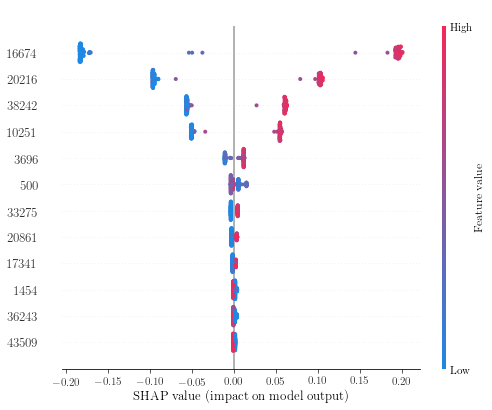

In [11]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 2. Removing zero- and near-zero-variance features

In [12]:
data = pd.read_csv('../data/model/data_int_NZ.csv', index_col=0)

In [13]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,7.048386,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.609438,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,2.079442,0.0,10.936547,5.855072,4.948760,...,6.833032,0.000000,6.811244,0.000000,8.238801,0.0,0.0,4.624973,4.406719,0.000000
19779,0.000000,6.434547,0.0,0.0,0.0,0.000000,0.0,10.746627,5.459586,4.812184,...,5.010635,7.937017,4.532599,7.762171,7.752335,0.0,0.0,4.174387,3.610918,7.487734
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,10.468489,5.726848,0.000000,...,3.526361,8.046229,0.000000,8.187855,0.000000,0.0,0.0,2.302585,3.583519,7.610358
19781,3.526361,6.654153,0.0,0.0,0.0,0.000000,0.0,11.021118,6.220590,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.850148,0.0,0.0,0.693147,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [14]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.048386,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,4.465908,0.000000,4.158883,1.386294,7.198184,0.0,4.941642,0.000000,4.330733,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,3.135494,3.218876,0.000000,0.0,11.247344,6.082219,4.770685,...,0,0,0,1,0,0,0,0,0,1
19818,4.584967,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.968268,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,3.258097,6.045005,3.610918,6.431331,0.0,10.557790,6.605298,5.087596,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [15]:
aucs, accs, shaps = crossval(features, target)

In [16]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.984253
std AUC: 0.007811
mean accuracy: 0.976009
std accuracy: 0.006732


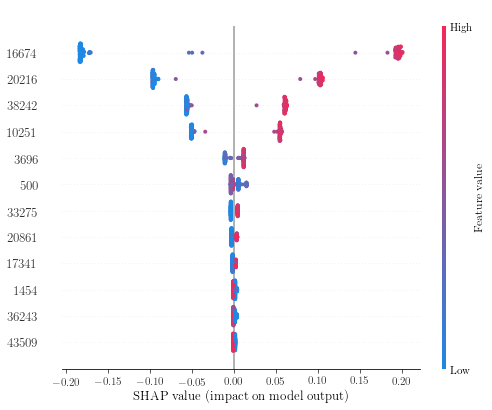

In [17]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 3. Clustering 0.99

In [6]:
data = pd.read_csv('../data/model/data_int_099.csv', index_col=0)

In [7]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,7.048386,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.609438,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,2.079442,0.0,10.936547,5.855072,4.948760,...,6.833032,0.000000,6.811244,0.000000,8.238801,0.0,0.0,4.624973,4.406719,0.000000
19779,0.000000,6.434547,0.0,0.0,0.0,0.000000,0.0,10.746627,5.459586,4.812184,...,5.010635,7.937017,4.532599,7.762171,7.752335,0.0,0.0,4.174387,3.610918,7.487734
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,10.468489,5.726848,0.000000,...,3.526361,8.046229,0.000000,8.187855,0.000000,0.0,0.0,2.302585,3.583519,7.610358
19781,3.526361,6.654153,0.0,0.0,0.0,0.000000,0.0,11.021118,6.220590,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.850148,0.0,0.0,0.693147,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [8]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.048386,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,4.465908,0.000000,4.158883,1.386294,7.198184,0.0,4.941642,0.000000,4.330733,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,3.135494,3.218876,0.000000,0.0,11.247344,6.082219,4.770685,...,0,0,0,1,0,0,0,0,0,1
19818,4.584967,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.968268,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,3.258097,6.045005,3.610918,6.431331,0.0,10.557790,6.605298,5.087596,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [9]:
aucs, accs, shaps = crossval(features, target)

In [10]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.984388
std AUC: 0.007800
mean accuracy: 0.976052
std accuracy: 0.006730


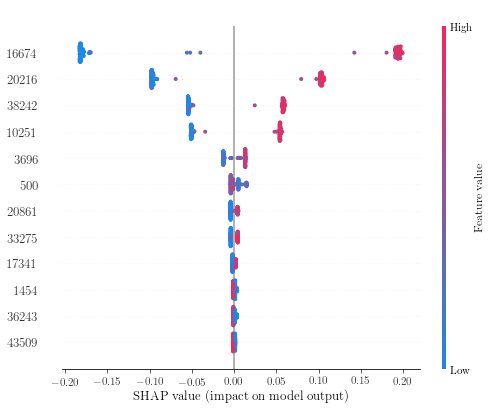

In [11]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 4. Clustering 0.95

In [13]:
data = pd.read_csv('../data/model/data_int_095.csv', index_col=0)

In [14]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44822,44824,44825,44827,44829,44830,44831,44832,44833,44834
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,7.048386,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.609438,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,2.079442,0.0,10.936547,5.855072,4.948760,...,5.840642,6.833032,0.000000,6.811244,0.000000,8.238801,0.0,0.0,4.624973,4.406719
19779,0.000000,6.434547,0.0,0.0,0.0,0.000000,0.0,10.746627,5.459586,4.812184,...,7.301148,5.010635,7.937017,4.532599,7.762171,7.752335,0.0,0.0,4.174387,3.610918
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,10.468489,5.726848,0.000000,...,7.003065,3.526361,8.046229,0.000000,8.187855,0.000000,0.0,0.0,2.302585,3.583519
19781,3.526361,6.654153,0.0,0.0,0.0,0.000000,0.0,11.021118,6.220590,0.000000,...,5.273000,0.000000,0.000000,0.000000,0.000000,3.850148,0.0,0.0,0.693147,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [15]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.048386,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,4.465908,0.000000,4.158883,1.386294,7.198184,0.0,4.941642,0.000000,4.330733,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,3.135494,3.218876,0.000000,0.0,11.247344,6.082219,4.770685,...,0,0,0,1,0,0,0,0,0,1
19818,4.584967,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12.968268,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,3.258097,6.045005,3.610918,6.431331,0.0,10.557790,6.605298,5.087596,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [16]:
aucs, accs, shaps = crossval(features, target)

In [17]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.984820
std AUC: 0.008047
mean accuracy: 0.975090
std accuracy: 0.006655


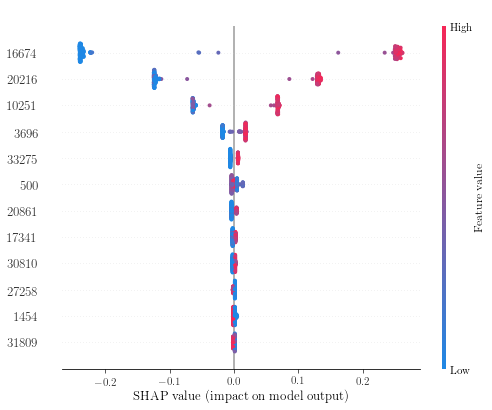

In [18]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 5. Clustering 0.9

In [20]:
data = pd.read_csv('../data/model/data_int_090.csv', index_col=0)

In [21]:
data.head()

,3,4,7,8,9,10,11,13,16,18,...,44815,44817,44822,44824,44827,44829,44830,44831,44832,44834
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,4.276666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,2.079442,0.0,5.855072,4.948760,0.000000,...,6.102559,5.111988,5.840642,6.833032,6.811244,0.000000,8.238801,0.0,0.0,4.406719
19779,0.000000,6.434547,0.0,0.0,0.0,0.000000,0.0,5.459586,4.812184,0.000000,...,4.882802,5.192957,7.301148,5.010635,4.532599,7.762171,7.752335,0.0,0.0,3.610918
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,5.726848,0.000000,0.000000,...,3.970292,0.000000,7.003065,3.526361,0.000000,8.187855,0.000000,0.0,0.0,3.583519
19781,3.526361,6.654153,0.0,0.0,0.0,0.000000,0.0,6.220590,0.000000,4.304065,...,2.639057,5.631212,5.273000,0.000000,0.000000,0.000000,3.850148,0.0,0.0,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [22]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,13,16,18,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,4.276666,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,4.465908,0.000000,4.158883,1.386294,7.198184,0.0,0.000000,4.330733,0.000000,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,3.135494,3.218876,0.000000,0.0,6.082219,4.770685,0.000000,...,0,0,0,1,0,0,0,0,0,1
19818,4.584967,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,3.258097,6.045005,3.610918,6.431331,0.0,6.605298,5.087596,0.000000,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [23]:
aucs, accs, shaps = crossval(features, target)

In [24]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.988973
std AUC: 0.006194
mean accuracy: 0.974729
std accuracy: 0.006717


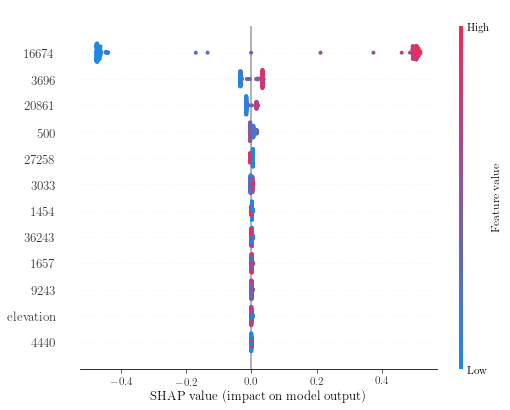

In [25]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

## 2. The AUC data

### 1. Removing zero-variance features

In [19]:
data = pd.read_csv('../data/model/data_auc_Z.csv', index_col=0)

In [20]:
data.head()

,0,1,3,4,5,6,7,8,9,10,...,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835
19777,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19778,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.101195,...,5.722303,6.641435,0.000000,0.000000,9.266512,0.000000,0.000000,4.545272,4.184018,0.000000
19779,0.0,0.0,0.000000,7.620365,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,3.612862,9.046775,9.133896,8.842752,8.680677,7.026730,3.759117,2.929005,9.290070
19780,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,9.295309,0.000000,8.209938,6.604423,0.000000,2.161252,8.741223
19781,0.0,0.0,4.975498,7.393971,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.261961,8.966053,7.254413,1.345212,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [21]:
features = data.join(metadata, how='inner')
features.head()

,0,1,3,4,5,6,7,8,9,10,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.0,0.0,0.000000,5.158147,0.0,0.0,0.000000,2.947985,0.0,9.278007,...,0,0,0,1,0,0,0,1,0,0
19817,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.847509,0.0,0.000000,...,0,0,0,1,0,0,0,0,0,1
19818,0.0,0.0,5.269941,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.530334,...,0,0,0,1,0,0,0,0,0,1
19819,0.0,0.0,0.000000,0.000000,0.0,0.0,2.180304,6.151886,0.0,7.972386,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [22]:
aucs, accs, shaps = crossval(features, target)

In [23]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.983429
std AUC: 0.007526
mean accuracy: 0.976650
std accuracy: 0.009907


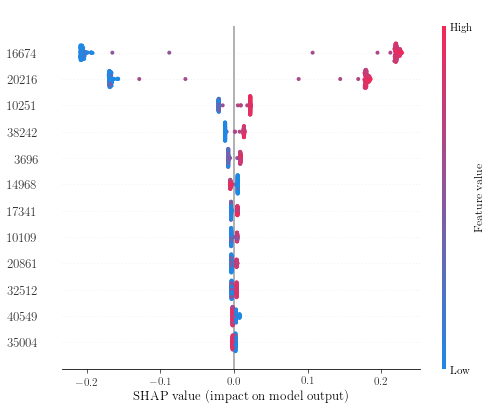

In [24]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 2. Removing zero- and near-zero-variance features

In [26]:
data = pd.read_csv('../data/model/data_auc_NZ.csv', index_col=0)

In [27]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,12.345647,7.198973,5.669381,...,7.049803,0.000000,6.641435,0.000000,9.266512,0.000000,0.000000,4.545272,4.184018,0.000000
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,12.008026,7.180381,4.709954,...,5.002570,9.061328,3.612862,9.133896,8.842752,8.680677,7.026730,3.759117,2.929005,9.290070
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,12.103745,7.111811,0.000000,...,2.384442,9.092586,0.000000,9.295309,0.000000,8.209938,6.604423,0.000000,2.161252,8.741223
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,13.275181,7.731493,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.261961,8.966053,7.254413,1.345212,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [28]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,6.201539,0.000000,2.837557,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,12.369872,7.641516,4.572001,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.530334,0.0,15.075935,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,12.206855,7.824531,5.766134,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [29]:
aucs, accs, shaps = crossval(features, target)

In [30]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.983429
std AUC: 0.007526
mean accuracy: 0.976650
std accuracy: 0.009907


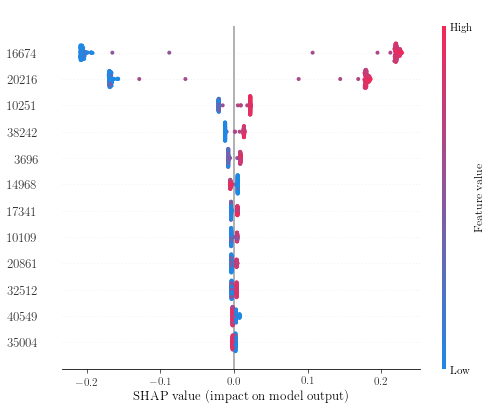

In [31]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 3. Clustering 0.99

In [27]:
data = pd.read_csv('../data/model/data_auc_099.csv', index_col=0)

In [28]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,12.345647,7.198973,5.669381,...,7.049803,0.000000,6.641435,0.000000,9.266512,0.000000,0.000000,4.545272,4.184018,0.000000
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,12.008026,7.180381,4.709954,...,5.002570,9.061328,3.612862,9.133896,8.842752,8.680677,7.026730,3.759117,2.929005,9.290070
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,12.103745,7.111811,0.000000,...,2.384442,9.092586,0.000000,9.295309,0.000000,8.209938,6.604423,0.000000,2.161252,8.741223
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,13.275181,7.731493,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.261961,8.966053,7.254413,1.345212,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [29]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,6.201539,0.000000,2.837557,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,12.369872,7.641516,4.572001,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.530334,0.0,15.075935,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,12.206855,7.824531,5.766134,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [30]:
aucs, accs, shaps = crossval(features, target)

In [31]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.983335
std AUC: 0.007496
mean accuracy: 0.976650
std accuracy: 0.009907


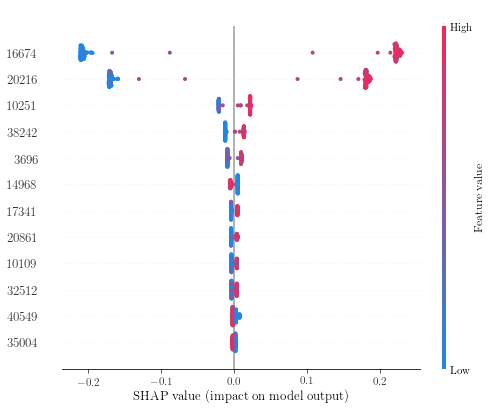

In [32]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 4. Clustering 0.95

In [34]:
data = pd.read_csv('../data/model/data_auc_095.csv', index_col=0)

In [35]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44822,44824,44825,44827,44829,44830,44831,44832,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,12.345647,7.198973,5.669381,...,7.155624,7.049803,0.000000,6.641435,0.000000,9.266512,0.000000,0.000000,4.184018,0.000000
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,12.008026,7.180381,4.709954,...,8.229853,5.002570,9.061328,3.612862,9.133896,8.842752,8.680677,7.026730,2.929005,9.290070
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,12.103745,7.111811,0.000000,...,8.103257,2.384442,9.092586,0.000000,9.295309,0.000000,8.209938,6.604423,2.161252,8.741223
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,13.275181,7.731493,0.000000,...,6.281615,0.000000,0.000000,0.000000,0.000000,4.261961,8.966053,7.254413,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [36]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,6.201539,0.000000,2.837557,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,12.369872,7.641516,4.572001,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.530334,0.0,15.075935,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,12.206855,7.824531,5.766134,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [37]:
aucs, accs, shaps = crossval(features, target)

In [38]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.983422
std AUC: 0.007735
mean accuracy: 0.977050
std accuracy: 0.009181


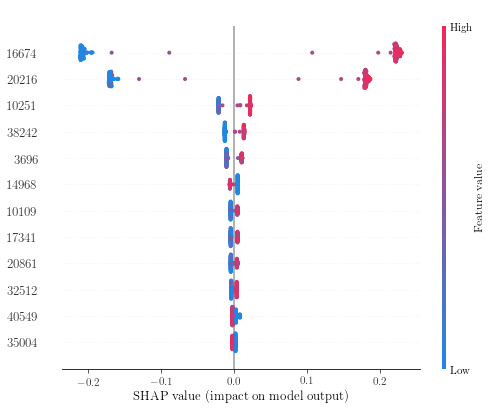

In [39]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 5. Clustering 0.9

In [41]:
data = pd.read_csv('../data/model/data_auc_090.csv', index_col=0)

In [42]:
data.head()

,3,4,7,8,9,10,11,13,16,18,...,44815,44817,44822,44824,44825,44827,44829,44830,44832,44834
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,5.849659,...,0.915290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,7.198973,5.669381,0.000000,...,7.367493,5.852095,7.155624,7.049803,0.000000,6.641435,0.000000,9.266512,0.000000,4.184018
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,7.180381,4.709954,0.000000,...,6.128191,5.866673,8.229853,5.002570,9.061328,3.612862,9.133896,8.842752,7.026730,2.929005
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,7.111811,0.000000,0.000000,...,4.633466,0.000000,8.103257,2.384442,9.092586,0.000000,9.295309,0.000000,6.604423,2.161252
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,7.731493,0.000000,4.640566,...,2.854514,6.335008,6.281615,0.000000,0.000000,0.000000,0.000000,4.261961,7.254413,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [43]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,13,16,18,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,5.849659,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,0.000000,2.837557,0.000000,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,7.641516,4.572001,0.000000,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.530334,0.0,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,7.824531,5.766134,0.000000,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [44]:
aucs, accs, shaps = crossval(features, target)

In [45]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.985363
std AUC: 0.005652
mean accuracy: 0.975835
std accuracy: 0.008452


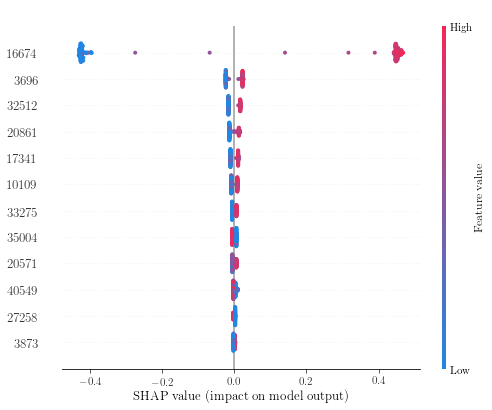

In [46]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

## The zeroed AUC data

### 1. Removing zero-variance features

In [33]:
data = pd.read_csv('../data/model/data_zauc_Z.csv', index_col=0)

In [34]:
data.head()

,0,1,3,4,5,6,7,8,9,10,...,44826,44827,44828,44829,44830,44831,44832,44833,44834,44835
19777,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
19778,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.101195,...,5.722303,6.641435,0.000000,0.000000,9.266512,0.0,0.0,4.545272,4.184018,0.000000
19779,0.0,0.0,0.000000,7.620365,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,3.612862,9.046775,9.133896,8.842752,0.0,0.0,3.759117,2.929005,9.290070
19780,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,9.295309,0.000000,0.0,0.0,0.000000,2.161252,8.741223
19781,0.0,0.0,4.975498,7.393971,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.261961,0.0,0.0,1.345212,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [35]:
features = data.join(metadata, how='inner')
features.head()

,0,1,3,4,5,6,7,8,9,10,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.0,0.0,0.000000,5.158147,0.0,0.0,0.000000,2.947985,0.0,9.278007,...,0,0,0,1,0,0,0,1,0,0
19817,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.847509,0.0,0.000000,...,0,0,0,1,0,0,0,0,0,1
19818,0.0,0.0,5.269941,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.0,0.0,0.000000,0.000000,0.0,0.0,2.180304,6.151886,0.0,7.972386,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [36]:
aucs, accs, shaps = crossval(features, target)

In [37]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.982677
std AUC: 0.007484
mean accuracy: 0.974076
std accuracy: 0.007999


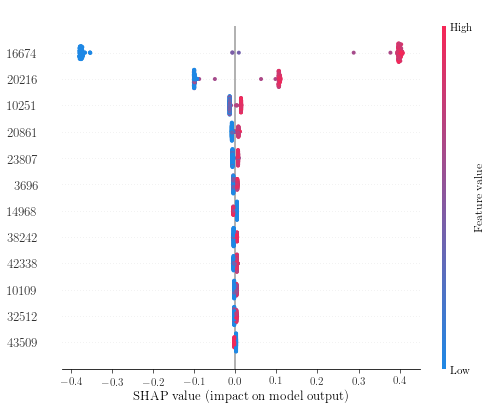

In [38]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 2. Removing zero- and near-zero-variance features

In [40]:
data = pd.read_csv('../data/model/data_zauc_NZ.csv', index_col=0)

In [41]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,12.345647,7.198973,5.669381,...,7.049803,0.000000,6.641435,0.000000,9.266512,0.0,0.0,4.545272,4.184018,0.000000
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,12.008026,7.180381,4.709954,...,5.002570,9.061328,3.612862,9.133896,8.842752,0.0,0.0,3.759117,2.929005,9.290070
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,12.103745,7.111811,0.000000,...,2.384442,9.092586,0.000000,9.295309,0.000000,0.0,0.0,0.000000,2.161252,8.741223
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,13.275181,7.731493,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.261961,0.0,0.0,1.345212,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [42]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,6.201539,0.000000,2.837557,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,12.369872,7.641516,4.572001,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.000000,0.0,15.075935,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,12.206855,7.824531,5.766134,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [43]:
aucs, accs, shaps = crossval(features, target)

In [44]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.982677
std AUC: 0.007484
mean accuracy: 0.974076
std accuracy: 0.007999


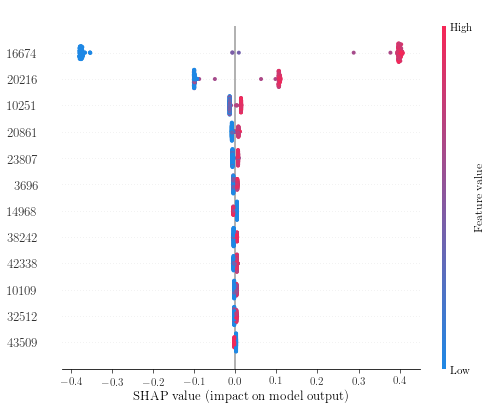

In [45]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 3. Clustering 0.99

In [48]:
data = pd.read_csv('../data/model/data_zauc_099.csv', index_col=0)

In [49]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44824,44825,44827,44829,44830,44831,44832,44833,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,12.345647,7.198973,5.669381,...,7.049803,0.000000,6.641435,0.000000,9.266512,0.0,0.0,4.545272,4.184018,0.000000
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,12.008026,7.180381,4.709954,...,5.002570,9.061328,3.612862,9.133896,8.842752,0.0,0.0,3.759117,2.929005,9.290070
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,12.103745,7.111811,0.000000,...,2.384442,9.092586,0.000000,9.295309,0.000000,0.0,0.0,0.000000,2.161252,8.741223
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,13.275181,7.731493,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.261961,0.0,0.0,1.345212,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [50]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,6.201539,0.000000,2.837557,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,12.369872,7.641516,4.572001,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.000000,0.0,15.075935,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,12.206855,7.824531,5.766134,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [51]:
aucs, accs, shaps = crossval(features, target)

In [52]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.982673
std AUC: 0.007475
mean accuracy: 0.974076
std accuracy: 0.007999


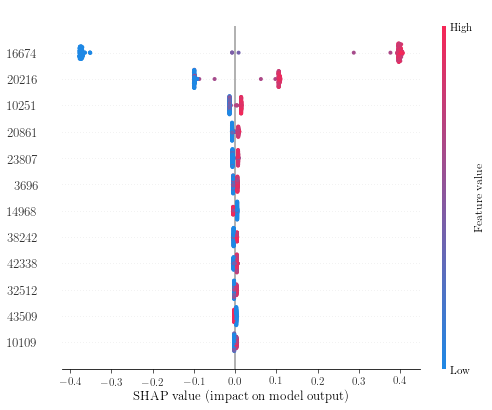

In [53]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 4. Clustering 0.95

In [55]:
data = pd.read_csv('../data/model/data_zauc_095.csv', index_col=0)

In [56]:
data.head()

,3,4,7,8,9,10,11,12,13,16,...,44822,44824,44825,44827,44829,44830,44831,44832,44834,44835
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,12.345647,7.198973,5.669381,...,7.155624,7.049803,0.000000,6.641435,0.000000,9.266512,0.0,0.0,4.184018,0.000000
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,12.008026,7.180381,4.709954,...,8.229853,5.002570,9.061328,3.612862,9.133896,8.842752,0.0,0.0,2.929005,9.290070
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,12.103745,7.111811,0.000000,...,8.103257,2.384442,9.092586,0.000000,9.295309,0.000000,0.0,0.0,2.161252,8.741223
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,13.275181,7.731493,0.000000,...,6.281615,0.000000,0.000000,0.000000,0.000000,4.261961,0.0,0.0,0.000000,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [57]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,12,13,16,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,9.265536,0.000000,0.000000,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,6.201539,0.000000,2.837557,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,12.369872,7.641516,4.572001,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.000000,0.0,15.075935,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,12.206855,7.824531,5.766134,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [58]:
aucs, accs, shaps = crossval(features, target)

In [59]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.982544
std AUC: 0.007651
mean accuracy: 0.974208
std accuracy: 0.007730


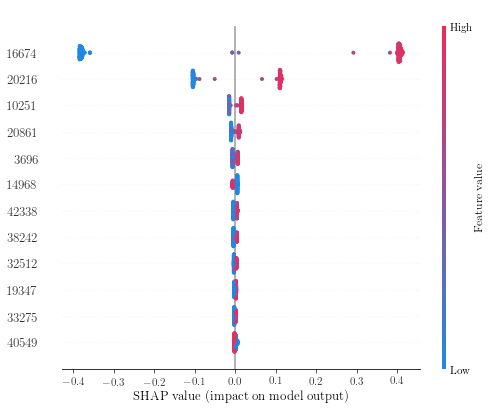

In [60]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

### 5. Clustering 0.9

In [62]:
data = pd.read_csv('../data/model/data_zauc_090.csv', index_col=0)

In [63]:
data.head()

,3,4,7,8,9,10,11,13,16,18,...,44815,44817,44822,44824,44827,44829,44830,44831,44832,44834
19777,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,5.849659,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
19778,0.000000,0.000000,0.0,0.0,0.0,3.101195,0.0,7.198973,5.669381,0.000000,...,7.367493,5.852095,7.155624,7.049803,6.641435,0.000000,9.266512,0.0,0.0,4.184018
19779,0.000000,7.620365,0.0,0.0,0.0,0.000000,0.0,7.180381,4.709954,0.000000,...,6.128191,5.866673,8.229853,5.002570,3.612862,9.133896,8.842752,0.0,0.0,2.929005
19780,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,7.111811,0.000000,0.000000,...,4.633466,0.000000,8.103257,2.384442,0.000000,9.295309,0.000000,0.0,0.0,2.161252
19781,4.975498,7.393971,0.0,0.0,0.0,0.000000,0.0,7.731493,0.000000,4.640566,...,2.854514,6.335008,6.281615,0.000000,0.000000,0.000000,4.261961,0.0,0.0,0.000000


Here we merge the metabolite data and the geographical metadata for each sample

In [64]:
features = data.join(metadata, how='inner')
features.head()

,3,4,7,8,9,10,11,13,16,18,...,province_mahasarakham,province_nakhonratchasima,province_phetchabuns,province_phitsanulok,province_saraburi,province_udonthani,soiltype_clay loam,soiltype_loam,soiltype_sand,soiltype_sandy loam
19777,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,5.849659,...,0,0,0,1,0,0,0,1,0,0
19789,0.000000,5.158147,0.000000,2.947985,0.0,9.278007,0.0,0.000000,2.837557,0.000000,...,0,0,0,1,0,0,0,1,0,0
19817,0.000000,0.000000,0.000000,1.847509,0.0,0.000000,0.0,7.641516,4.572001,0.000000,...,0,0,0,1,0,0,0,0,0,1
19818,5.269941,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,1
19819,0.000000,0.000000,2.180304,6.151886,0.0,7.972386,0.0,7.824531,5.766134,0.000000,...,0,0,0,1,0,0,0,0,0,1


We now run CV

In [65]:
aucs, accs, shaps = crossval(features, target)

In [66]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.983429
std AUC: 0.007792
mean accuracy: 0.973015
std accuracy: 0.009065


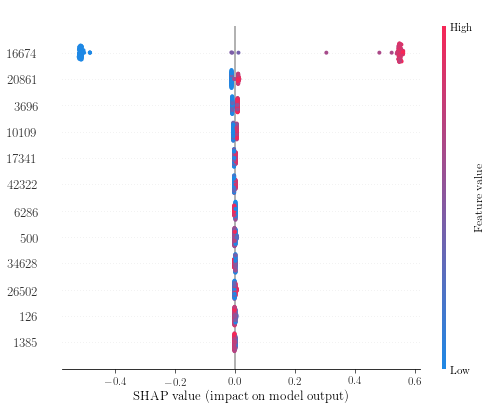

In [67]:
shap.summary_plot(shaps, features, max_display=12, plot_type='dot')

# Other predictions

From the results above, we see that:

1. For all three datasets, the removal of near-zero-variance features has no effect on the model. That is, when only zero-variance features are removed, the near-zero-variance features are still completely ignored.

2. None of the geographical features are ranked among the most important predictors.

3. Very few compounds seem to have a large impact on model output.

## 1. No metadata

We test the performance of the model when no geographical information is available. We do this only for the smallest datasets, *ie.*, those clustered with threshold 0.9.

### 1. Intensity data

In [107]:
data = pd.read_csv('../data/model/data_int_090.csv', index_col=0)
data = data.loc[metadata.index]

In [108]:
aucs, accs, shaps = crossval(data, target)

In [109]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.988870
std AUC: 0.006160
mean accuracy: 0.974684
std accuracy: 0.006739


### 2. AUC data

In [110]:
data = pd.read_csv('../data/model/data_auc_090.csv', index_col=0)
data = data.loc[metadata.index]

In [111]:
aucs, accs, shaps = crossval(data, target)

In [112]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.985104
std AUC: 0.005474
mean accuracy: 0.975793
std accuracy: 0.008673


### 3. Zeroed AUC data

In [113]:
data = pd.read_csv('../data/model/data_zauc_090.csv', index_col=0)
data = data.loc[metadata.index]

In [114]:
aucs, accs, shaps = crossval(data, target)

In [115]:
print('mean AUC: %f' %np.mean(aucs))
print('std AUC: %f' %np.std(aucs))
print('mean accuracy: %f' %np.mean(accs))
print('std accuracy: %f' %np.std(accs))

mean AUC: 0.982999
std AUC: 0.007760
mean accuracy: 0.973327
std accuracy: 0.007884


## 2. Single-feature predictions

We use the 3 most important features from the clustered datasets, and all members of their given clusters, one feature at a time.

In [76]:
def searchcluster(column, links):
    cluster = [column]
    
    found = links[links.col1 == column].col2.values.tolist()
    
    cluster.extend(found)
    
    while len(found)>0:
        found2 = links[links.col1 == found[0]].col2.values
        found2 = np.setdiff1d(found2,cluster).tolist()
        found.extend(found2)
        cluster.extend(found2)
        found.remove(found[0])
    return cluster

### 1. Intensity data

In [91]:
data = pd.read_csv('../data/model/data_int_NZ.csv', index_col=0)
data = data.loc[metadata.index]
links = pd.read_csv('../data/links090_int.csv', index_col=0)
links.col1 = links.col1.values.astype(str) 
links.col2 = links.col2.values.astype(str) 
sorted_feats = ['16674', '3696', '20861']

In [92]:
summary = pd.DataFrame(columns=['feature', 'cluster', 'mean AUC', 'std AUC', 'mean accuracy', 'std accuracy'])
for i, parent in enumerate(sorted_feats):
    if parent not in links.col1.values:
        cluster = [parent]
    else:
        cluster = searchcluster(parent, links)
    results = pd.DataFrame({'feature': cluster, 'cluster': (i+1)*np.ones(len(cluster))})
    
    aucmean = []
    aucstd = []
    accmean = []
    accstd = []
    
    for child in cluster:
        aucs, accs, shaps = crossval(data[child], target)
        aucmean.append(np.mean(aucs))
        aucstd.append(np.std(aucs))
        accmean.append(np.mean(accs))
        accstd.append(np.std(accs))
    
    results['mean AUC'] = aucmean
    results['std AUC'] = aucstd
    results['mean accuracy'] = accmean
    results['std accuracy'] = accstd
    
    summary = pd.concat([summary, results], axis=0)

summary = summary.reset_index().drop(['index'], axis=1)

In [94]:
summary.sort_values(by='mean AUC', ascending=False).head()

,feature,cluster,mean AUC,std AUC,mean accuracy,std accuracy
0,16674,1.0,0.983685,0.003276,0.975358,0.004796
1,20216,1.0,0.981360,0.003152,0.978559,0.004953
6,38242,1.0,0.978943,0.004441,0.975927,0.004255
5,33275,1.0,0.975946,0.002015,0.970307,0.006394
7,3696,2.0,0.974932,0.004026,0.950632,0.006311


In [95]:
summary.to_csv('../data/model/summary_int.csv', index=False)

### 2. AUC data

In [96]:
data = pd.read_csv('../data/model/data_auc_NZ.csv', index_col=0)
data = data.loc[metadata.index]
links = pd.read_csv('../data/links090_auc.csv', index_col=0)
links.col1 = links.col1.values.astype(str) 
links.col2 = links.col2.values.astype(str) 
sorted_feats = ['16674', '3696', '32512']

In [97]:
summary = pd.DataFrame(columns=['feature', 'cluster', 'mean AUC', 'std AUC', 'mean accuracy', 'std accuracy'])
for i, parent in enumerate(sorted_feats):
    if parent not in links.col1.values:
        cluster = [parent]
    else:
        cluster = searchcluster(parent, links)
    results = pd.DataFrame({'feature': cluster, 'cluster': (i+1)*np.ones(len(cluster))})
    
    aucmean = []
    aucstd = []
    accmean = []
    accstd = []
    
    for child in cluster:
        aucs, accs, shaps = crossval(data[child], target)
        aucmean.append(np.mean(aucs))
        aucstd.append(np.std(aucs))
        accmean.append(np.mean(accs))
        accstd.append(np.std(accs))
    
    results['mean AUC'] = aucmean
    results['std AUC'] = aucstd
    results['mean accuracy'] = accmean
    results['std accuracy'] = accstd
    
    summary = pd.concat([summary, results], axis=0)

summary = summary.reset_index().drop(['index'], axis=1)

In [98]:
summary.sort_values(by='mean AUC', ascending=False).head()

,feature,cluster,mean AUC,std AUC,mean accuracy,std accuracy
1,20216,1.0,0.985963,0.001796,0.976246,0.004861
0,16674,1.0,0.981673,0.001336,0.976719,0.004947
2,38242,1.0,0.979673,0.005034,0.962500,0.005968
4,32512,3.0,0.977905,0.002331,0.963403,0.007488
3,3696,2.0,0.974970,0.005359,0.949735,0.006071


In [99]:
summary.to_csv('../data/model/summary_auc.csv', index=False)

### 3. Zeroed AUC data

In [100]:
data = pd.read_csv('../data/model/data_zauc_NZ.csv', index_col=0)
data = data.loc[metadata.index]
links = pd.read_csv('../data/links090_zauc.csv', index_col=0)
links.col1 = links.col1.values.astype(str) 
links.col2 = links.col2.values.astype(str) 
sorted_feats = ['16674', '20861', '3696']

In [101]:
summary = pd.DataFrame(columns=['feature', 'cluster', 'mean AUC', 'std AUC', 'mean accuracy', 'std accuracy'])
for i, parent in enumerate(sorted_feats):
    if parent not in links.col1.values:
        cluster = [parent]
    else:
        cluster = searchcluster(parent, links)
    results = pd.DataFrame({'feature': cluster, 'cluster': (i+1)*np.ones(len(cluster))})
    
    aucmean = []
    aucstd = []
    accmean = []
    accstd = []
    
    for child in cluster:
        aucs, accs, shaps = crossval(data[child], target)
        aucmean.append(np.mean(aucs))
        aucstd.append(np.std(aucs))
        accmean.append(np.mean(accs))
        accstd.append(np.std(accs))
    
    results['mean AUC'] = aucmean
    results['std AUC'] = aucstd
    results['mean accuracy'] = accmean
    results['std accuracy'] = accstd
    
    summary = pd.concat([summary, results], axis=0)

summary = summary.reset_index().drop(['index'], axis=1)

In [102]:
summary.sort_values(by='mean AUC', ascending=False).head()

,feature,cluster,mean AUC,std AUC,mean accuracy,std accuracy
1,20216,1.0,0.984245,0.002188,0.975060,0.005963
0,16674,1.0,0.984187,0.003509,0.973777,0.003569
4,38242,1.0,0.980181,0.003791,0.963556,0.006157
2,32512,1.0,0.975282,0.002640,0.964246,0.007017
6,3696,3.0,0.973523,0.003683,0.949781,0.007506


In [103]:
summary.to_csv('../data/model/summary_zauc.csv', index=False)

### Properties of the three best predictors

We find that, in all cases, the three best predictors are part of the same cluster and correspond to metabolites 16674, 20216 and 38242. From the table of metabolite properties we find:

In [106]:
peaks = pd.read_csv('../data/peak_IDs.csv')
peaks.iloc[[16674,20216,38242]]

,m/z,retention time,n peaks
16674,155.069762,7.568337,90.0
20216,368.140123,7.564014,85.0
38242,367.136409,7.566092,141.0
